In [1]:
# Task:
# Turn data into "images"
# Two networks
# GAN: generate atoms and bonds (adjacency) layers
# simple CNN: turning SMILES layer to atoms+bonds layers

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from numpy import ndarray
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

# loading SMILES data using Chainer Chemistry
from chainer_chemistry.datasets.molnet import get_molnet_dataset
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset
from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor, construct_atomic_number_array

# import necessary libraries
import os
import glob

from rdkit import Chem

from scipy.stats import pearsonr
# using packages from utils
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, './../utils/')
from general import hartree_to_ev
from general import read_csv_concat

2023-05-31 16:19:46.331113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 16:19:46.405628: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-31 16:19:46.767205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-05-31 16:19:46.767255: W tensorflow/compile

In [2]:
path = './../data/trainingsets/highgap_outliergen_trans1/gen_outliers/'
data_gen = read_csv_concat(path=path)

File Name: ./../data/trainingsets/highgap_outliergen_trans1/gen_outliers/outliers3332.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/gen_outliers/outliers3607.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/gen_outliers/outliers8207.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/gen_outliers/outliers9951.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/gen_outliers/outliers3734.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/gen_outliers/outliers7476.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/gen_outliers/outliers5312.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/gen_outliers/outliers7654.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/gen_outliers/outliers2843.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/gen_outliers/outliers3050.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/gen_outliers/outliers8367.csv
File Name:

In [3]:
"""Chem.MolFromSmiles('CC1CC(O)C2(CC2)O1')"""

preprocessor = GGNNPreprocessor()
#atom_num = construct_atomic_number_array()
#data_gen = pd.read_csv('./outliers17.csv')
data_gen0 = data_gen.copy()

gen_smiles = []
idx = []
for i, smile in enumerate(data_gen['SMILES']):
    try:
        gen_smiles.append (Chem.MolToSmiles(Chem.MolFromSmiles(smile, sanitize=True), canonical=True))
        idx.append(i)
    except:
        print (smile)
        pass
idx = np.array(idx)
data_gen = data_gen.iloc[idx]
data_gen = data_gen.reset_index(drop=True)

In [4]:

print ('Test all gen smiles are canonical:', 
       sum(gen_smiles==data_gen['SMILES'])==data_gen.shape[0])
print (gen_smiles[0])


data_gen = data_gen.drop_duplicates(subset=['SMILES'], keep='first').reset_index(drop=True)

gen_smiles = data_gen['SMILES']
try:
    DFT_gap = data_gen['DFT_gap']
except:
    DFT_gap = data_gen['pred_gap']

Test all gen smiles are canonical: True
CCC1OC2CCCCC1C2C


In [5]:
sum(gen_smiles==data_gen['SMILES'])==data_gen.shape[0]

True

In [6]:
path = './../data/trainingsets/highgap_outliergen_trans1/dft_evaluated/'
data_gen_previus = read_csv_concat(path=path)

File Name: ./../data/trainingsets/highgap_outliergen_trans1/dft_evaluated/gap_larg9p5_dft.csv


In [7]:
data_gen = data_gen.reset_index(drop=True)
data_gen

,SMILES,pred_gap
0,CCC1OC2CCCCC1C2C,9.280075
1,CCCCCCCC(CCCC)CCCCCO,9.058806
2,CCCC(CCC)CCC1CC(C(C)OC)C1C,9.026749
3,CCCCCC1(CCC)CCCCCC1CCC,9.589881
4,CCCCCCC(C)CC(C)CCCCCO,9.037078
...,...,...
88903,CCOCC(CC)(CC)C(C)CC,9.396623
88904,CCCCC1CCC(C)CC(C(CC)CCO)CC1,9.528848
88905,CCCC1CCC2CCCC(C)C12C,9.451074
88906,CCC1CC2C1C21CCCCC1C,9.032561


In [8]:
data_gen_previus

,SMILES,DFT_gap
0,CCC1CCC2CCC12,9.586576
1,CC1C2CC1C2,10.718571
2,CC1OC1(C)C1CC1,9.540317
3,CCC1(C)CCC1,9.747124
4,CC1CC(C)(C2CO2)C1,9.575691
...,...,...
1021,CCCCCCCC1CO1,9.558542
1022,CC1CCC(C)C(C)C1C,9.721811
1023,CCC1CCC(C)(C)CC1,9.557726
1024,CCC12CCCC3C1CCC32,9.514460


In [9]:
# find the repetitives from train
previous_rep = pd.merge(data_gen, data_gen_previus, on = 'SMILES', how = 'inner')
print ("Same generated SMILES compared to pubqc: \n{}".format(previous_rep))

Same generated SMILES compared to pubqc: 
              SMILES   pred_gap    DFT_gap
0      CC1CCCCCCCCC1   9.355068   9.665755
1     CC(C)CC(C)(C)C   9.644280  10.011074
2        CCC1CCCCC1C   9.536013   9.804267
3      CCC(C)CC(C)CC   9.752762  10.166179
4    CC1CCCCCCC(C)C1   9.587040   9.660313
..               ...        ...        ...
165  CC(C)CC(C)C1CC1  10.161345   9.597461
166      CCCC(C)(C)C   9.655691  10.226044
167  CC(C)C(C)CC1CC1   9.810597   9.621950
168      CCC1CCCC1CC   9.547525  10.136247
169  CC(C)(C)CC1CCC1   9.460062   9.572970

[170 rows x 3 columns]


PearsonRResult(statistic=0.2508364010141304, pvalue=0.0009693116243726915)


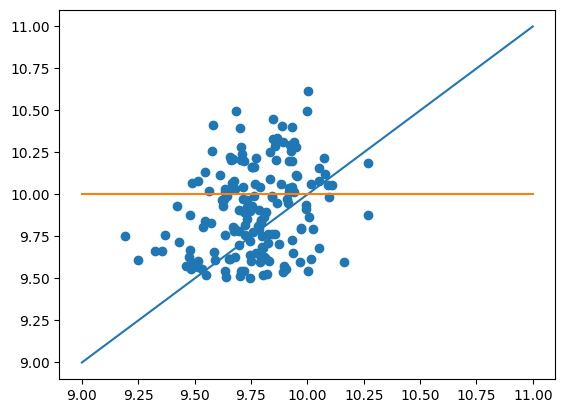

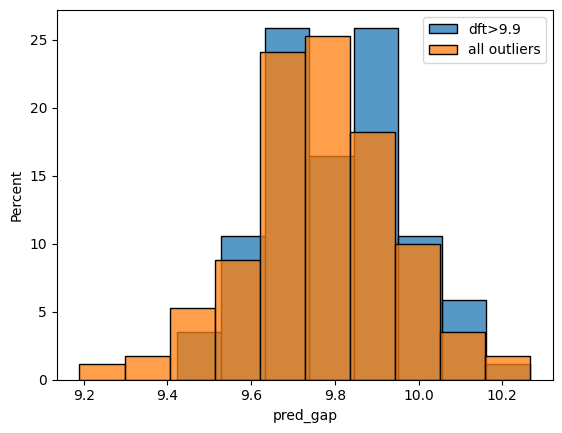

In [10]:
try:
    plt.scatter(previous_rep['pred_gap'], previous_rep['DFT_gap'])
    print (pearsonr(previous_rep['pred_gap'], previous_rep['DFT_gap']))
    plt.plot ([9, 11], [9, 11])
    plt.plot ([9, 11], [10, 10])
    plt.show()
    plt.close()
    sns_dft = sns.histplot (previous_rep['pred_gap'].loc[previous_rep['DFT_gap']>=9.9], 
                  stat='percent', bins=8, label='dft>9.9')
    sns.histplot (previous_rep['pred_gap'], stat='percent', 
                   label='all outliers', bins=10)
    plt.legend()
    plt.show()
except Exception as e:
    print (e)

In [11]:
data_gen.loc[data_gen['pred_gap']>10].to_csv('./temp.csv')

In [12]:
rep_smiles = previous_rep['SMILES']
for i in range(data_gen.shape[0]):
    if (data_gen['SMILES'].loc[i] in list(rep_smiles)):
        print (i)
        data_gen = data_gen.drop(i)

217
225
949
1176
1185
1611
1893
2804
2811
3144
3177
3525
3642
3684
3741
3743
3753
4042
4917
4952
5159
5402
5717
6527
6606
6772
7012
7207
7459
7928
7984
8901
8996
9259
9273
9286
9349
9916
9931
10499
10669
11020
11027
11181
11412
11729
12405
13263
13286
13500
14039
14300
14728
15681
15989
16465
16498
17403
19273
19492
20376
20671
21788
22243
22394
22701
23143
23769
23983
24731
25623
25770
26120
27103
27534
28177
28609
28870
29007
29687
30011
30538
30576
32652
32900
33367
33886
34283
34435
35059
35233
35901
36767
37123
38265
38416
38930
39138
39428
40265
40360
40432
40597
41306
42030
42352
44165
44519
44747
45235
46031
46412
46781
46782
47080
47236
47430
47576
47687
50991
51220
51615
51821
52690
53374
54743
54961
55733
56167
56400
56885
59497
60487
60838
61204
61931
61934
62497
62623
62806
63099
63532
63987
65291
66114
66753
67153
69730
69808
69850
70090
71750
72391
73055
74094
75240
76269
77109
79274
79431
80103
81998
83087
84233
85307
87976


In [13]:
data_gen

,SMILES,pred_gap
0,CCC1OC2CCCCC1C2C,9.280075
1,CCCCCCCC(CCCC)CCCCCO,9.058806
2,CCCC(CCC)CCC1CC(C(C)OC)C1C,9.026749
3,CCCCCC1(CCC)CCCCCC1CCC,9.589881
4,CCCCCCC(C)CC(C)CCCCCO,9.037078
...,...,...
88903,CCOCC(CC)(CC)C(C)CC,9.396623
88904,CCCCC1CCC(C)CC(C(CC)CCO)CC1,9.528848
88905,CCCC1CCC2CCCC(C)C12C,9.451074
88906,CCC1CC2C1C21CCCCC1C,9.032561


In [14]:
data_gen = data_gen.drop_duplicates(subset=['SMILES'], keep='first').reset_index(drop=True)

gen_smiles = data_gen['SMILES']
try:
    DFT_gap = data_gen['DFT_gap']
except:
    DFT_gap = data_gen['pred_gap']

In [15]:
print (data_gen.shape)
print (len(gen_smiles))
print (len(DFT_gap))

(88742, 2)
88742
88742


<Axes: xlabel='pred_gap', ylabel='Count'>

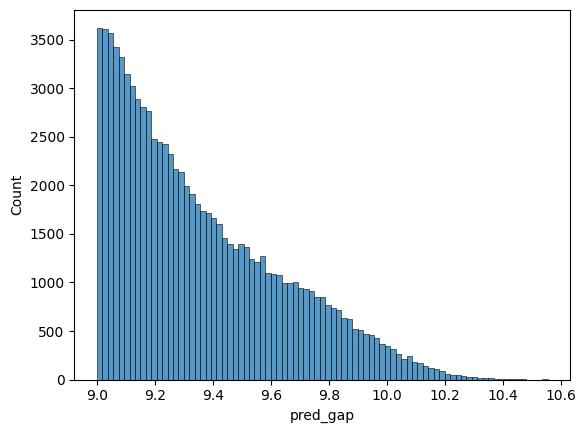

In [16]:
sns.histplot (data_gen['pred_gap'])

In [17]:
with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer_object.pickle', 'rb') as f:
    tokenizer_ = pickle.load(f)

with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

In [18]:
X_smiles = []
for smile in gen_smiles:
    print (smile)
    m  = Chem.MolFromSmiles(smile, sanitize=True)
    smiles_can = Chem.MolToSmiles(m, canonical=True)
    smiles_can_dot = smiles_can + '.'
    X_smiles0 = tokenizer_.texts_to_sequences([smiles_can_dot])
    X_smiles1 = pad_sequences(X_smiles0, maxlen = 40, padding = 'post')
    X_smiles2 = to_categorical(X_smiles1, num_classes=27)
    SHAPE = list(X_smiles2.shape[1:])+[1]
    X_smiles2 = X_smiles2.reshape(SHAPE)
    X_smiles.append(X_smiles2)

CCC1OC2CCCCC1C2C
CCCCCCCC(CCCC)CCCCCO
CCCC(CCC)CCC1CC(C(C)OC)C1C
CCCCCC1(CCC)CCCCCC1CCC
CCCCCCC(C)CC(C)CCCCCO
CCCCCCCCC1CCCC1CCCC
CCCCCC(CC)CCCCC(C)C
CCCCCCCC(C)COC1(C)CCCCCC1
CCOC1CCC1CC1CCCC1C
COC(O)(CCCCC(C)C)CC(C)CCCO
CC(C)C1CCCCCCCCCCC1
CCCC(C)C1CCCCCC(C)C1
CCCCCC1CCCC(CCCC)C1
CCCC1CCCCC(CC)CCCC1
CC1CCCCCCCCC1CC1CCCC1
CC1CCCCCOCC(O)OC(C)O1
CCOCCC(C)(C)CC
CCOCCCC(C)(C)C(C)C1CC1CC
CCCC1C(C)CC2CC(C)(C)C21
CCCCCCCCCCCC(C)CC
CCCCC(CC(C)CC)C(C)C
CCC1CC(C)C(C)CCCCC1C
CCCCCCCCCCC(C)CC(C)C
CCC12CCCCCCCC1CCCCC2
CCCCC(CC)CCC1CC(C)C1
CCCCCCCCC(C)COCCCCCCC
CCCC(C)COCCOC(O)CC
CCC(C)(C(C)C)C(C)C
CCCCCCCC(O)(OC)C(C)C
CCCCCC(CCC(CCCC)C1CCC1CO)C(C)CC
CC1CCCCCCCCOCCCCCC1
CC1OC2CCC3CC3(C)OC(C)C12
CCCCCCC(CCCO)COCCCCC(C)C
CCC1CCCCCC(CCC(C)C)CCC1C
CCCCCCCC1CCCC1OC
COCOCCCCC1CCCCCC2C(C)OC12
CCCCCCCC(CCCCl)CCCCC
CCCCCCCCCC(C)OC1CO1
CCCCC(C)CC1CC(CCC)C1
CCCCCCCC(CC)CCCC1CC1C
CCC(C)C(CC)CC(C)(C)CC(C)C
CCCCCC1C(C)CCCCC2CCC21
CCCCCC(C)CCCOCCC
CCCCCC(C)CCC1CC1CC
CC1CCCCCCCCCCCCCCC1C
CCC1CCC(COC)OCCCCOC1
CCC1C

In [19]:
X_smiles = np.array (X_smiles)

In [20]:
DFT_gap.shape

(88742,)

<Axes: xlabel='pred_gap', ylabel='Count'>

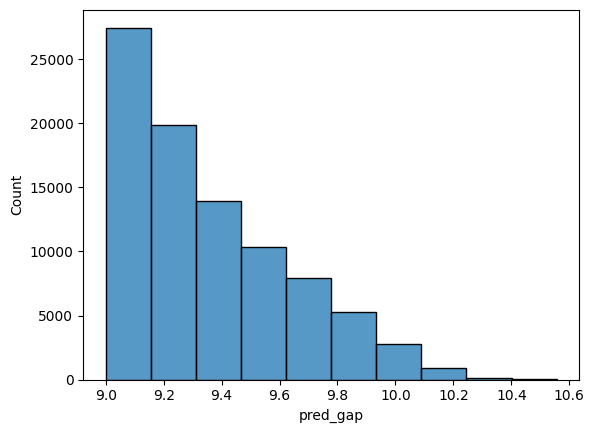

In [21]:
sns.histplot (DFT_gap, bins=10)

In [22]:
#val_accurate.to_csv('gen_new_noscreen_all_joback.csv', index = False)
preprocessor = GGNNPreprocessor()

with open('./../data/trainingsets/image.pickle', 'rb') as f:
    X_smiles_pubqc, SMILES_pubqc, gap_pubqc = pickle.load(f)
    
with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '

with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer_object.pickle', 'rb') as f:
    tokenizer_ = pickle.load(f)

In [23]:
# save as canonical SMILES to find duplicates
# the gen smiles already converted to Canonical
SMILES_pubqc_can = []
for s in SMILES_pubqc:
    try:
        m = Chem.MolFromSmiles (s[:-1])
        ss = Chem.MolToSmiles(m)
        SMILES_pubqc_can.append(ss)
    except Exception as error:
        print (error)
#SMILES = SMILES.astype('str')
print ('First SMILES in pubqc', SMILES_pubqc[0])
print (np.array(SMILES_pubqc).shape)
print (SMILES_pubqc.shape)
SMILES_pubqc_can = np.array(SMILES_pubqc_can)
data_pubqc = {}
data_pubqc ['SMILES'] = SMILES_pubqc_can
data_pubqc ['gap'] = gap_pubqc
data_pubqc = pd.DataFrame(data_pubqc)

First SMILES in pubqc Nc1nc[nH]c2ncnc1-2.
(132626,)
(132626,)


In [24]:
# find the repetitives from train
database_samples_rep = pd.merge(gen_smiles, data_pubqc, on = 'SMILES', how = 'inner')
print ( "Same generated SMILES compared to pubqc: \n{}".format(database_samples_rep))

Same generated SMILES compared to pubqc: 
                     SMILES     gap
0       CC(C)C1CCCCCCCCCCC1   9.693
1         CCCCCCCCCCCC(C)CC  10.264
2        CCC(C)(C(C)C)C(C)C   9.712
3      CCC(C)CCC(CC)CCC(C)C   9.965
4     CCCCCCCCCC(C)CC(C)CCC   9.908
...                     ...     ...
2639   CCCC(CC)CCCC(C)(C)CC   9.856
2640     CCCC(C)C(C)C(C)CCC   9.753
2641       CCC1CC(C)C(C)C1C   9.823
2642           CC(C)C1OC1CO   8.585
2643   CCC1CC2CCC(CC)(C1)C2   9.696

[2644 rows x 2 columns]


In [25]:
database_samples_rep = pd.merge(data_pubqc, gen_smiles, on = 'SMILES', how = 'inner')
database_samples_rep

,SMILES,gap
0,CC1CCCC(C(C)C(C)C)O1,8.319000
1,CCCCCCC1CCOC1C,8.351000
2,C1CCCCCCCOCCCCCC1,8.384000
3,CCCCC(CC)CCC(C)O,8.846000
4,CCCCCCCCCCCCCO,8.879000
...,...,...
2639,CCCCCCCC(C)CC1CCC1,9.905000
2640,CCC(C)CCCCCC(C)CC(C)C,9.989000
2641,CC1CCC2(C)CCCC12,9.910000
2642,CCCCCCC1(C)CCCC1,9.915829


In [26]:
rep_smiles = database_samples_rep['SMILES']
for i in range(gen_smiles.shape[0]):
    if (gen_smiles[i] in list(rep_smiles)):
        print (i)
        gen_smiles = gen_smiles.drop(i)
        DFT_gap = DFT_gap.drop(i)

10
19
27
60
71
75
79
92
93
110
115
120
164
179
183
187
190
194
200
202
209
218
236
239
248
264
281
289
296
302
318
322
328
349
362
389
425
426
428
431
473
490
506
508
535
567
577
600
602
614
623
633
641
651
655
677
692
698
700
702
706
711
745
750
751
760
798
799
804
808
815
824
833
840
845
866
868
906
909
942
945
951
971
975
1002
1014
1025
1039
1064
1065
1080
1082
1085
1087
1090
1091
1109
1117
1141
1143
1148
1163
1181
1182
1183
1185
1192
1223
1226
1233
1245
1265
1273
1288
1301
1307
1316
1319
1349
1356
1358
1360
1398
1405
1415
1418
1438
1443
1459
1464
1466
1474
1495
1505
1507
1528
1547
1553
1578
1589
1590
1593
1608
1629
1631
1636
1657
1658
1670
1671
1706
1719
1721
1726
1750
1759
1760
1785
1820
1823
1826
1837
1838
1861
1863
1866
1882
1887
1892
1895
1916
1931
1936
1956
1959
1962
1978
2011
2014
2043
2051
2067
2071
2079
2085
2098
2103
2104
2120
2128
2188
2197
2214
2225
2241
2259
2279
2288
2292
2307
2310
2312
2376
2378
2381
2402
2417
2424
2426
2478
2509
2513
2521
2531
2533
2538
2539
2542
254

In [31]:
gen_data_new = pd.DataFrame({})
gen_data_new ['SMILES'] = gen_smiles
gen_data_new ['pred_gap'] = DFT_gap

In [32]:
gen_data_new.shape

(86098, 2)

In [36]:
gen_data_new_higher10pred = gen_data_new.loc[gen_data_new ['pred_gap']>10]
gen_data_new_higher10pred.shape

(2077, 2)

In [35]:
# double check the samples not being in PubchemQC
database_samples_rep = pd.merge(gen_data_new_higher10pred, data_pubqc, on = 'SMILES', how = 'inner')
print ( "Same generated SMILES compared to pubqc: \n{}".format(database_samples_rep))

Same generated SMILES compared to pubqc: 
Empty DataFrame
Columns: [SMILES, pred_gap, gap]
Index: []


In [41]:
gen_data_new_higher10pred.iloc[0:1000].reset_index(drop=True).to_csv('./Bhupalee_highgap_samples1000.csv')

In [42]:
gen_data_new_higher10pred.iloc[1000:].reset_index(drop=True).to_csv('./kia_highgap_samplesNext1000.csv')

In [27]:
gen_smiles0 = []
for smile in gen_smiles:
    s_dot = smile + '.'
    gen_smiles0.append(s_dot)
gen_smiles0 = np.array(gen_smiles0)

In [28]:
SMILES_nodot = []
for i in gen_smiles0:
    smile = i[:-1]
    SMILES_nodot.append(smile)
SMILES_nodot = np.array (SMILES_nodot)

In [30]:
SMILES_nodot.shape

(86098,)

In [31]:
output = pd.DataFrame({})
output ['SMILES'] = SMILES_nodot[0:400]
output ['pred_gap'] = DFT_gap[0:400].to_list()
output.to_csv('./Bhupalee.csv')

In [32]:
output = pd.DataFrame({})
output ['SMILES'] = SMILES_nodot[400:800]
output ['pred_gap'] = DFT_gap[400:800].to_list()
output.to_csv('./../data/trainingsets/lowgap_outliergen_trans1/gen_outliers/yxie_gen_outlier.csv')

In [33]:
output = pd.DataFrame({})
output ['SMILES'] = SMILES_nodot[800:1200]
output ['pred_gap'] = DFT_gap[800:1200].to_list()
output.to_csv('./../data/trainingsets/lowgap_outliergen_trans1/gen_outliers/cz9n3_gen_outlier.csv')

In [34]:
output = pd.DataFrame({})
output ['SMILES'] = SMILES_nodot[1200:]
output ['pred_gap'] = DFT_gap[1200:].to_list()
output.to_csv('./../data/trainingsets/lowgap_outliergen_trans1/gen_outliers/linjian_gen_outlier.csv')

In [36]:
output = pd.DataFrame({})
output ['SMILES'] = SMILES_nodot
output ['pred_gap'] = DFT_gap.to_list()
output.to_csv('./../data/trainingsets/lowgap_outliergen_trans1/gen_outliers/mixed_gen_outlier2.csv')

In [35]:
# subsampling
idx = np.random.choice(len(DFT_gap), int(len(DFT_gap) * 0.8), replace = False)
X_smiles_train, SMILES_train, y_train = (X_smiles[idx], 
                                         gen_smiles0[idx], 
                                         DFT_gap[idx])

idx_test = np.setdiff1d(list(range(len(DFT_gap))), idx)
X_smiles_test, SMILES_test, y_test = (X_smiles[idx_test], 
                                      gen_smiles0[idx_test], 
                                      DFT_gap[idx_test])

In [27]:
# need DFT evaluation for creating the dataset.
"""
with open('./../data/trainingsets/lowgap_outliergen_trans1/image.pickle', 'wb') as f:
    pickle.dump((X_smiles, gen_smiles0, DFT_gap), f)
    
with open('./../data/trainingsets/lowgap_outliergen_trans1/image_train.pickle', 'wb') as f:
    pickle.dump((X_smiles_train, SMILES_train, y_train), f)
    
with open('./../data/trainingsets/lowgap_outliergen_trans1/image_test.pickle', 'wb') as f:
    pickle.dump((X_smiles_test, SMILES_test, y_test), f)
"""
